In [15]:
!pip install scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-16-3f18f9bf93d1>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Transformed_Imputed_and_cleaned_data_with_region.csv')


Pivot completed! Saved to '/content/pivoted_transformed_data.csv'
Pivoted shape: (1368, 1942)
Series Name Country Name  Year Quarter  Economic_Resilience
0                Albania  2021       0                    0
1                Albania  2021       0                    0
2                Albania  2021      Q1                    0
3                Albania  2021      Q2                    0
4                Albania  2021      Q3                    0
Filtered Annual Indicator Data (First Few Rows):
Series Name Country Name  Year  Total reserves (includes gold, current US$)  \
0                Albania  2021                                    20.743095   
1                Albania  2021                                          NaN   
6                Albania  2022                                    20.685539   
7                Albania  2022                                          NaN   
12               Albania  2023                                    20.858877   

Series Name  Rule of L

<ipython-input-16-3f18f9bf93d1>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Economic_Resilience', y='Count', data=resilience_counts_df, palette='viridis')


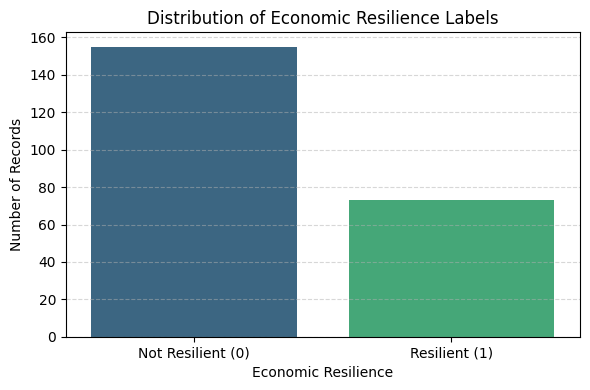

   Economic_Resilience  Count
0                    0    155
1                    1     73


In [16]:
df = pd.read_csv('/content/Transformed_Imputed_and_cleaned_data_with_region.csv')
required_cols = ['Country Name','Country Code', 'Year', 'Quarter', 'Series Name', 'Region', 'Value_Transformed']
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Pivot table
pivot_df = df.pivot_table(
    index=['Country Name', 'Country Code', 'Year', 'Quarter'],
    columns='Series Name',
    values='Value_Transformed'
).reset_index()

pivot_df.to_csv('/content/pivoted_transformed_data.csv', index=False)
print("Pivot completed! Saved to '/content/pivoted_transformed_data.csv'")
print(f"Pivoted shape: {pivot_df.shape}")

positive_indicators = [
    'Total reserves (includes gold, current US$)',
    'Rule of Law: Percentile Rank',
    'Industrial design applications, resident, by count',
    'GDP growth (annual %)',
    'Current account balance (% of GDP)',
    'Foreign direct investment, net inflows (% of GDP)'
]

negative_indicators = [
    'Value lost due to electrical outages (% of sales for affected firms)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)'
]

pivot_copy = pivot_df.copy()

for col in positive_indicators:
    mean = pivot_df[col].mean()
    std = pivot_df[col].std()
    pivot_copy[f'{col}_bin'] = (pivot_df[col] >= (mean - std)).astype(int)

for col in negative_indicators:
    mean = pivot_df[col].mean()
    std = pivot_df[col].std()
    pivot_copy[f'{col}_bin'] = (pivot_df[col] <= (mean + std)).astype(int)

# Compute final resilience score as average of binary features
bin_cols = [col for col in pivot_copy.columns if col.endswith('_bin')]
pivot_copy['Economic_Resilience'] = (pivot_copy[bin_cols].mean(axis=1) >= 0.6).astype(int)

print(pivot_copy[['Country Name', 'Year', 'Quarter', 'Economic_Resilience']].head())
pivot_copy.to_csv('/content/econ_resilience_with_flag.csv', index=False)
annual_indicators = [
    'Total reserves (includes gold, current US$)',
    'Rule of Law: Percentile Rank',
    'Industrial design applications, resident, by count',
    'GDP growth (annual %)',
    'Current account balance (% of GDP)',
    'Foreign direct investment, net inflows (% of GDP)',
    'Value lost due to electrical outages (% of sales for affected firms)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)'
]
pivot_copy['Quarter'] = pivot_copy['Quarter'].astype(str)

# Filter for annual data only
annual_only = pivot_copy[pivot_copy['Quarter'] == '0']
annual_data = annual_only[['Country Name', 'Year'] + annual_indicators + ['Economic_Resilience']]
print("Filtered Annual Indicator Data (First Few Rows):")
print(annual_data.head())
annual_data.to_csv('/content/Annual_Economic_Indicators.csv', index=False)

indicators_with_resilience = annual_indicators + ['Economic_Resilience']
annual_aggregated = annual_only.groupby(['Country Name', 'Year'], as_index=False)[indicators_with_resilience].first()
print("Deduplicated Annual Data:")
print(annual_aggregated.head())

annual_aggregated.to_csv('/content/Annual_Economic_Indicators_Cleaned.csv', index=False)

df = pd.read_csv('/content/Annual_Economic_Indicators_Cleaned.csv')
resilience_counts = df['Economic_Resilience'].value_counts().sort_index()
resilience_counts.name = 'Count'
resilience_counts_df = resilience_counts.reset_index()
resilience_counts_df.columns = ['Economic_Resilience', 'Count']
plt.figure(figsize=(6, 4))
sns.barplot(x='Economic_Resilience', y='Count', data=resilience_counts_df, palette='viridis')
plt.title('Distribution of Economic Resilience Labels')
plt.xlabel('Economic Resilience')
plt.ylabel('Number of Records')
plt.xticks([0, 1], ['Not Resilient (0)', 'Resilient (1)'])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(resilience_counts_df)

Class distribution:
Economic_Resilience
0    155
1     73
Name: count, dtype: int64
Class balance: 32.02% resilient
Training set shape: (171, 8)
Testing set shape: (57, 8)
Logistic Regression Results:
Accuracy: 0.8947
Precision: 0.8333
Recall: 0.8333
F1 Score: 0.8333
ROC AUC: 0.9473
5-Fold CV F1: 0.7827 (±0.0971)


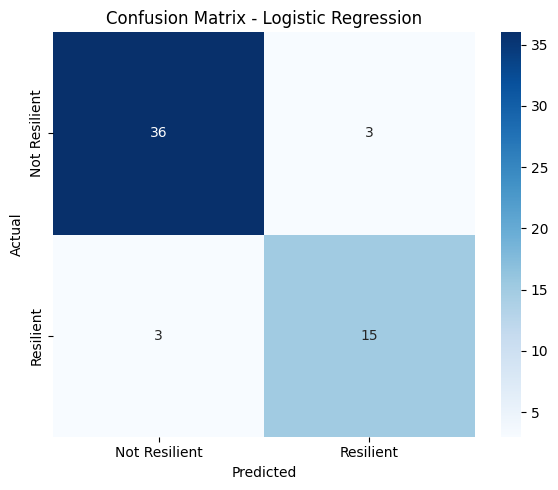


Classification Report:
               precision    recall  f1-score   support

Not Resilient       0.92      0.92      0.92        39
    Resilient       0.83      0.83      0.83        18

     accuracy                           0.89        57
    macro avg       0.88      0.88      0.88        57
 weighted avg       0.89      0.89      0.89        57



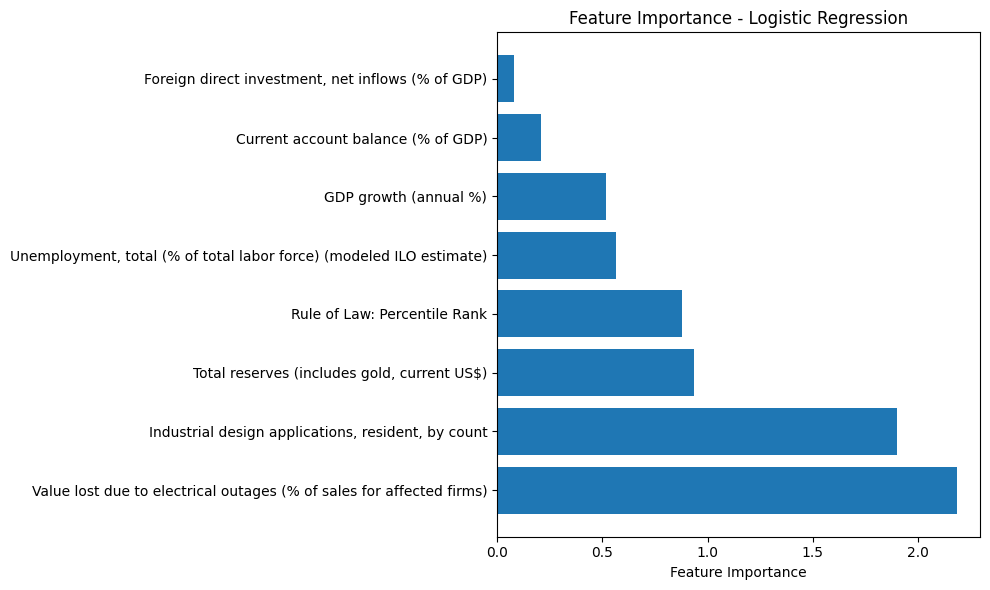

Decision Tree Results:
Accuracy: 0.9825
Precision: 1.0000
Recall: 0.9444
F1 Score: 0.9714
ROC AUC: 0.9722
5-Fold CV F1: 0.9512 (±0.0355)


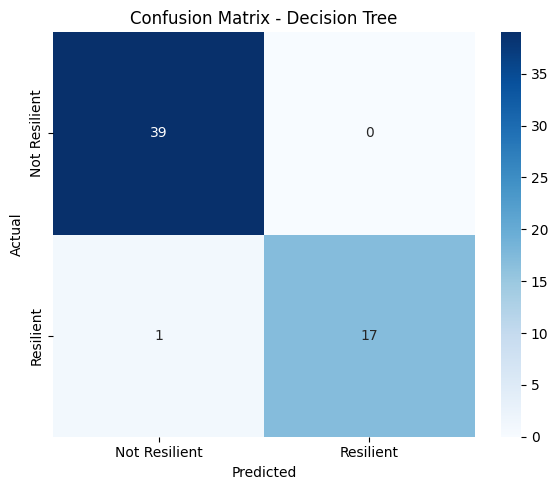


Classification Report:
               precision    recall  f1-score   support

Not Resilient       0.97      1.00      0.99        39
    Resilient       1.00      0.94      0.97        18

     accuracy                           0.98        57
    macro avg       0.99      0.97      0.98        57
 weighted avg       0.98      0.98      0.98        57



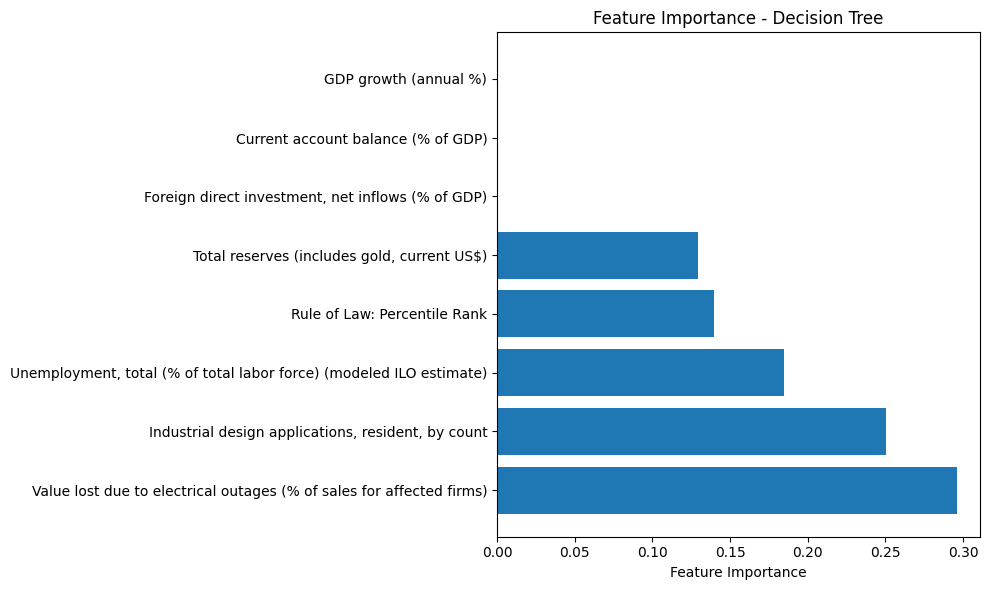

Random Forest Results:
Accuracy: 0.9649
Precision: 1.0000
Recall: 0.8889
F1 Score: 0.9412
ROC AUC: 0.9907
5-Fold CV F1: 0.9418 (±0.0298)


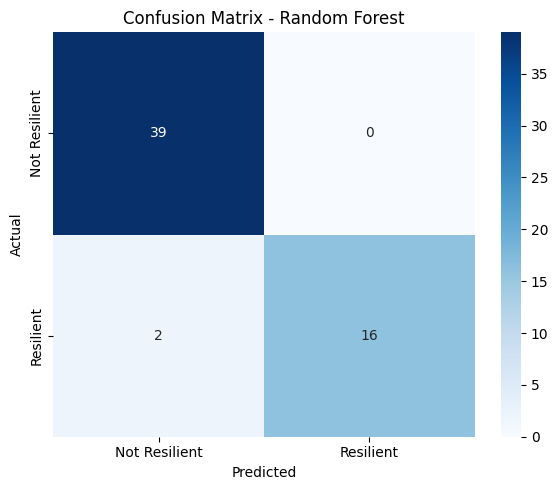


Classification Report:
               precision    recall  f1-score   support

Not Resilient       0.95      1.00      0.97        39
    Resilient       1.00      0.89      0.94        18

     accuracy                           0.96        57
    macro avg       0.98      0.94      0.96        57
 weighted avg       0.97      0.96      0.96        57



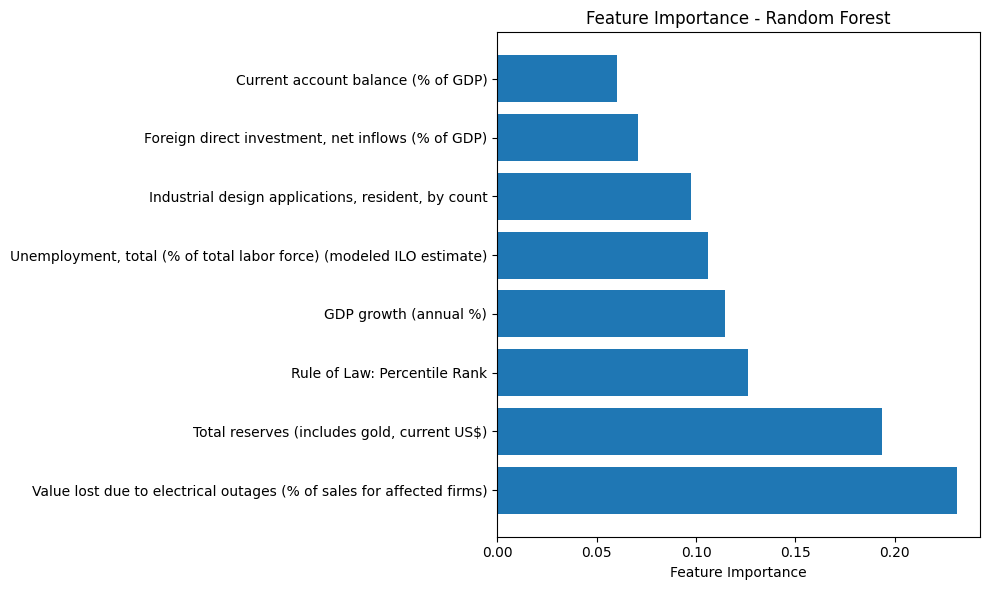

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:10:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:10:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:10:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:10:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:10:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Results:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
5-Fold CV F1: 0.9719 (±0.0267)


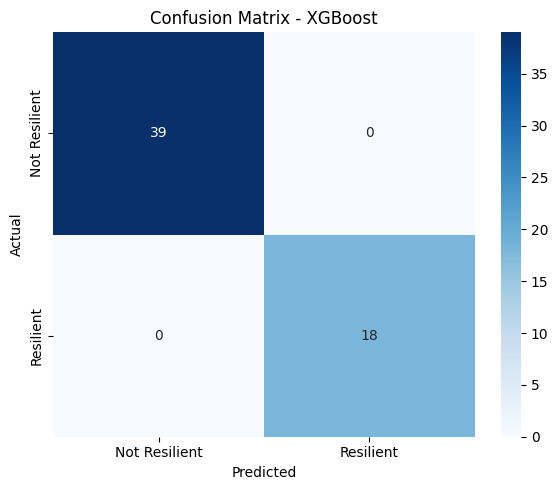


Classification Report:
               precision    recall  f1-score   support

Not Resilient       1.00      1.00      1.00        39
    Resilient       1.00      1.00      1.00        18

     accuracy                           1.00        57
    macro avg       1.00      1.00      1.00        57
 weighted avg       1.00      1.00      1.00        57



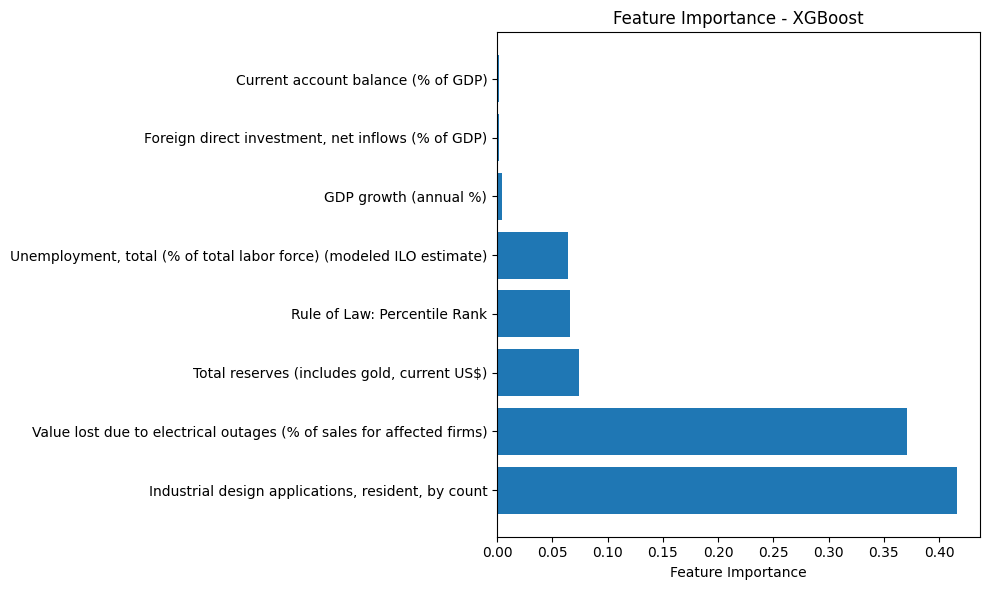

<Figure size 1200x800 with 0 Axes>

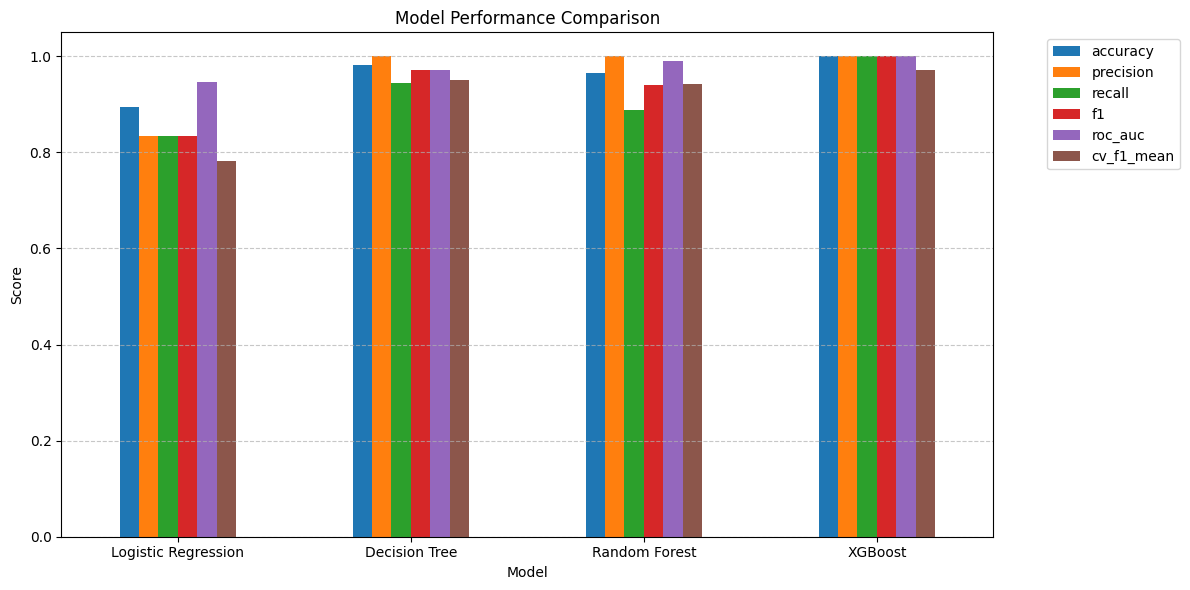

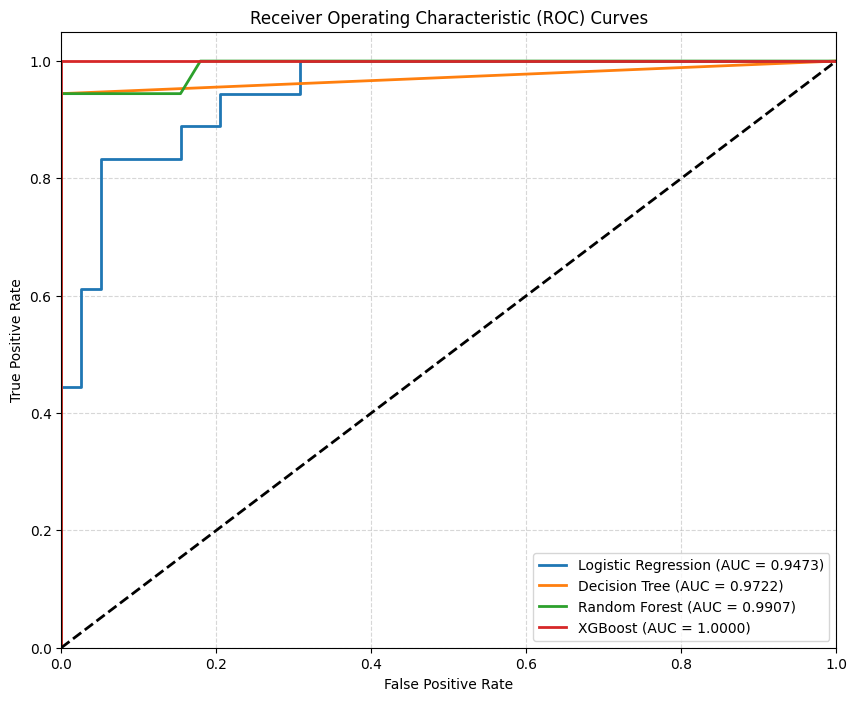

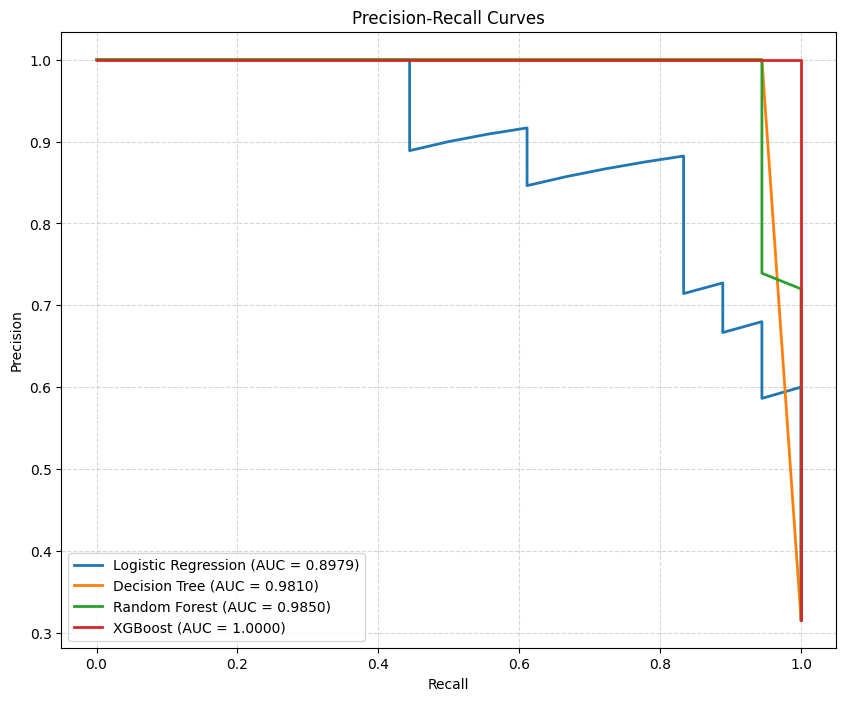

SUMMARY OF MODEL COMPARISON
Best model for accuracy: XGBoost with score 1.0000
Best model for precision: Decision Tree with score 1.0000
Best model for recall: XGBoost with score 1.0000
Best model for f1: XGBoost with score 1.0000
Best model for roc_auc: XGBoost with score 1.0000
Best model for cv_f1_mean: XGBoost with score 0.9719

Recommendation:
The XGBoost model performs best overall, with highest F1 and ROC AUC scores.


In [17]:
df = pd.read_csv('/content/Annual_Economic_Indicators_Cleaned.csv')
X = df.drop(['Country Name', 'Year', 'Economic_Resilience'], axis=1)
y = df['Economic_Resilience']
print(f"Class distribution:\n{y.value_counts()}")
print(f"Class balance: {y.mean()*100:.2f}% resilient")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled = X_scaled.fillna(X_scaled.mean())
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), # Balances classes
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)
        if isinstance(y_prob, np.ndarray) and y_prob.shape[1] == 2:
            y_prob = y_prob[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1')

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"5-Fold CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Resilient', 'Resilient'],
                yticklabels=['Not Resilient', 'Resilient'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Resilient', 'Resilient']))

    # Feature importance
    if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
        plt.figure(figsize=(10, 6))

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            importances = model.coef_[0]

        indices = np.argsort(np.abs(importances))[::-1]

        plt.barh(range(len(indices)), np.abs(importances)[indices])
        plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance - {name}')
        plt.tight_layout()
        plt.show()

    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std()
    }

results = {}
for name, model in models.items():
    results[name] = evaluate_model(name, model, X_train, X_test, y_train, y_test)

# Compare models performance
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_f1_mean']
comparison = pd.DataFrame({name: [results[name][metric] for metric in metrics]
                           for name in models.keys()},
                          index=metrics)

plt.figure(figsize=(12, 8))
comparison.T.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ROC curves for all models
plt.figure(figsize=(10, 8))

for name, result in results.items():
    model = result['model']

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)
        if isinstance(y_prob, np.ndarray) and y_prob.shape[1] == 2:
            y_prob = y_prob[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Precision-Recall curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    model = result['model']

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)
        if isinstance(y_prob, np.ndarray) and y_prob.shape[1] == 2:
            y_prob = y_prob[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("SUMMARY OF MODEL COMPARISON")
best_models = {}
for metric in metrics:
    best_model = comparison.loc[metric].idxmax()
    best_score = comparison.loc[metric].max()
    best_models[metric] = (best_model, best_score)
    print(f"Best model for {metric}: {best_model} with score {best_score:.4f}")

print("\nRecommendation:")

best_f1 = best_models['f1'][0]
best_roc = best_models['roc_auc'][0]

if best_f1 == best_roc:
    print(f"The {best_f1} model performs best overall, with highest F1 and ROC AUC scores.")
else:
    print(f"Consider using the {best_f1} model for best F1 score or {best_roc} for best ROC AUC.")
    print("For imbalanced datasets like this one, prioritize F1 score and precision-recall AUC over accuracy.")

Dataset shape: (228, 11)

Columns in the dataset:
['Country Name', 'Year', 'Total reserves (includes gold, current US$)', 'Rule of Law: Percentile Rank', 'Industrial design applications, resident, by count', 'GDP growth (annual %)', 'Current account balance (% of GDP)', 'Foreign direct investment, net inflows (% of GDP)', 'Value lost due to electrical outages (% of sales for affected firms)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)', 'Economic_Resilience']

Missing values per column:
Country Name                                                            0
Year                                                                    0
Total reserves (includes gold, current US$)                             0
Rule of Law: Percentile Rank                                            0
Industrial design applications, resident, by count                      0
GDP growth (annual %)                                                   0
Current account balance (% of GDP)    

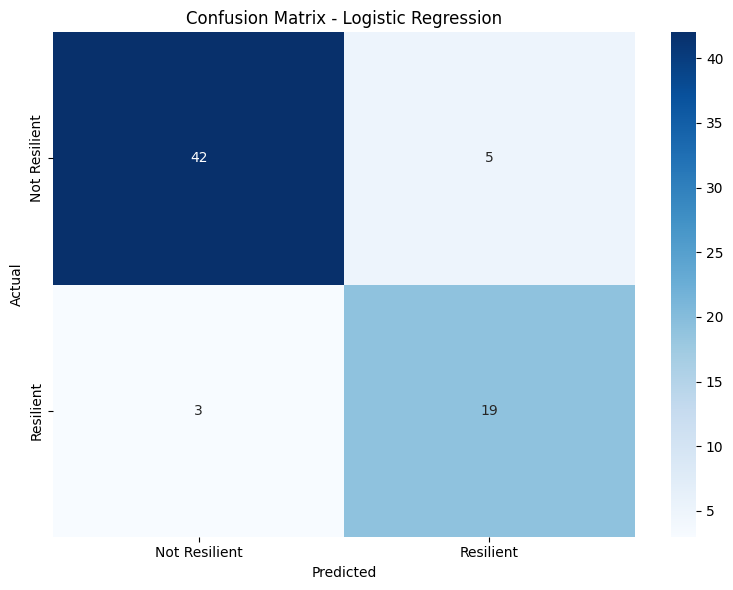


Classification Report:
               precision    recall  f1-score   support

Not Resilient       0.93      0.89      0.91        47
    Resilient       0.79      0.86      0.83        22

     accuracy                           0.88        69
    macro avg       0.86      0.88      0.87        69
 weighted avg       0.89      0.88      0.89        69



<ipython-input-14-32342cb2a369>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Coefficient', y='Feature', data=coef_df, palette='viridis')


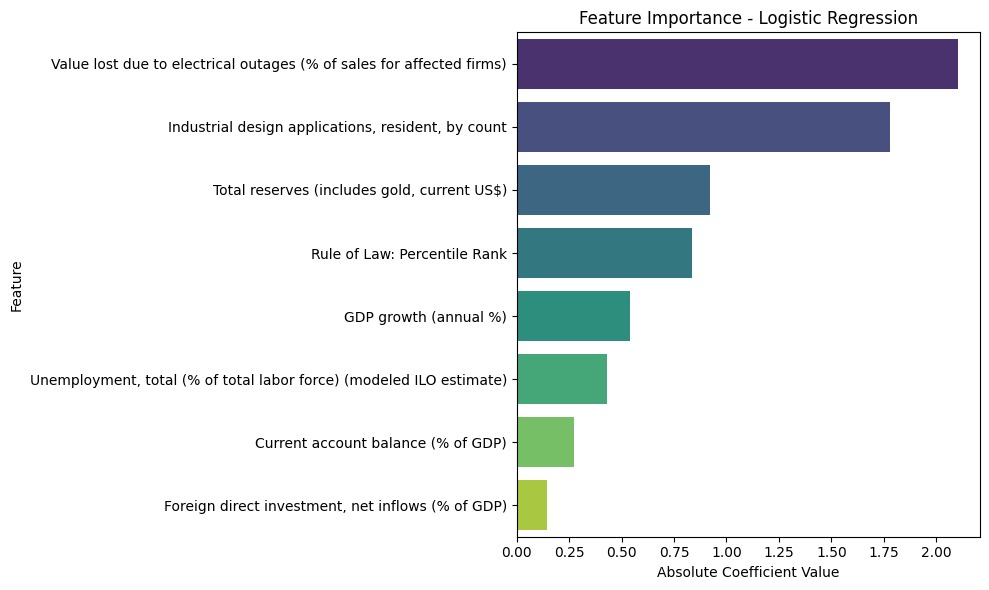

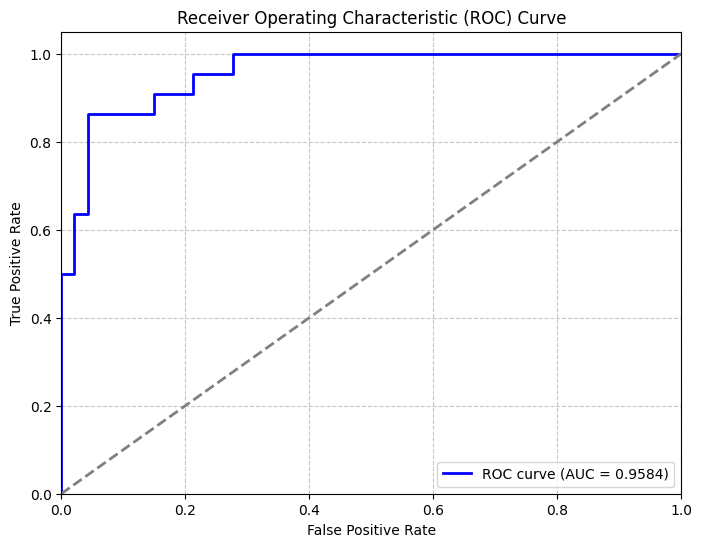

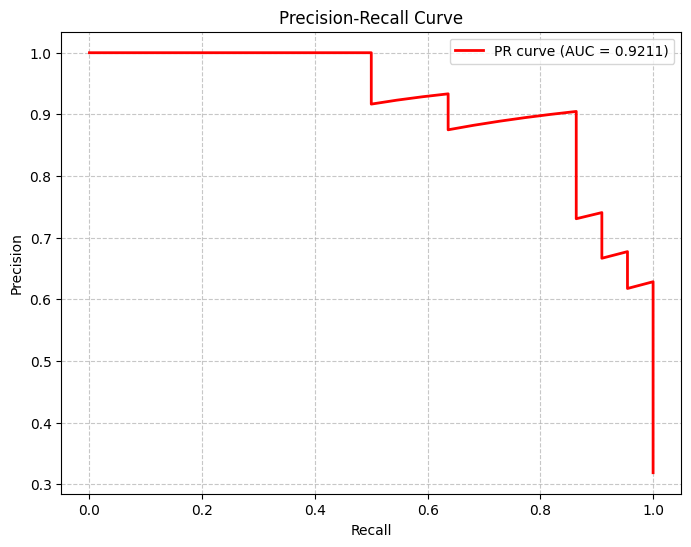

ODDS RATIOS (SORTED)
                                             Feature  Odds_Ratio Direction
2  Industrial design applications, resident, by c...    5.921850  Positive
0        Total reserves (includes gold, current US$)    2.513586  Positive
1                       Rule of Law: Percentile Rank    2.301850  Positive
5  Foreign direct investment, net inflows (% of GDP)    0.866398  Negative
4                 Current account balance (% of GDP)    0.760629  Negative
7  Unemployment, total (% of total labor force) (...    0.649472  Negative
3                              GDP growth (annual %)    0.582824  Negative
6  Value lost due to electrical outages (% of sal...    0.122069  Negative


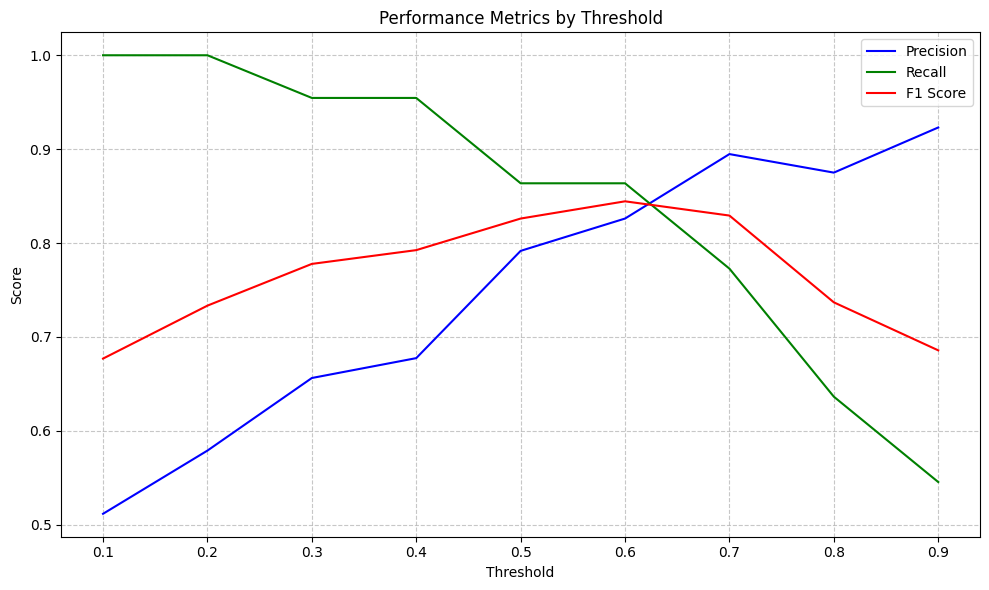


Optimal threshold for F1 score: 0.60
At this threshold - Precision: 0.8261, Recall: 0.8636, F1: 0.8444


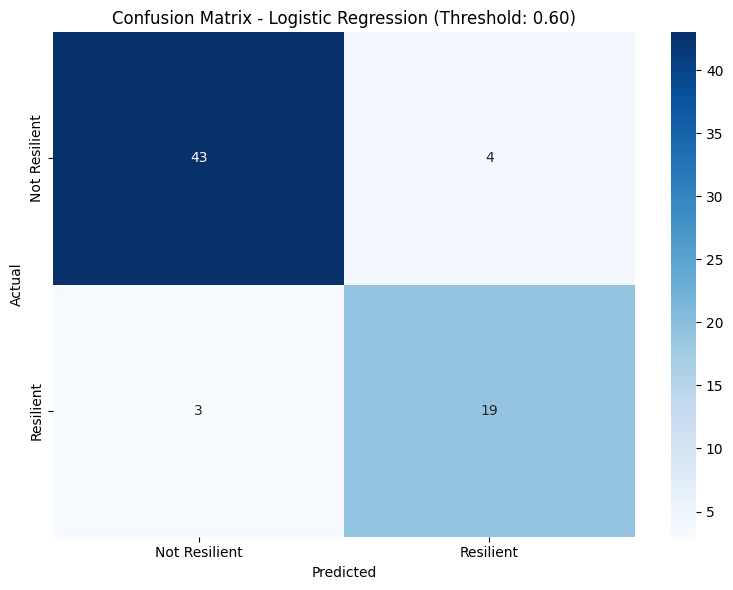


Final Classification Report (with optimal threshold):
               precision    recall  f1-score   support

Not Resilient       0.93      0.91      0.92        47
    Resilient       0.83      0.86      0.84        22

     accuracy                           0.90        69
    macro avg       0.88      0.89      0.88        69
 weighted avg       0.90      0.90      0.90        69

MODEL INTERPRETATION SUMMARY
Top positive indicators of economic resilience:
- Industrial design applications, resident, by count: 5.92 times higher odds
- Total reserves (includes gold, current US$): 2.51 times higher odds
- Rule of Law: Percentile Rank: 2.30 times higher odds

Top negative indicators of economic resilience:
- Foreign direct investment, net inflows (% of GDP): 1.15 times lower odds
- Current account balance (% of GDP): 1.31 times lower odds
- Unemployment, total (% of total labor force) (modeled ILO estimate): 1.54 times lower odds

Model prediction example:
For a new country, if all fea

In [14]:
np.random.seed(42)
df = pd.read_csv('/content/Annual_Economic_Indicators_Cleaned.csv')
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())

print("\nMissing values per column:")
print(df.isnull().sum())

X = df.drop(['Country Name', 'Year', 'Economic_Resilience'], axis=1)
y = df['Economic_Resilience']

print("\nClass distribution:")
print(y.value_counts())
print(f"Class balance: {y.mean()*100:.2f}% resilient")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Logistic regression model
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)

# Train the model
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='f1')

print("LOGISTIC REGRESSION PERFORMANCE")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"5-Fold CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0],
    'Abs_Coefficient': abs(logreg.coef_[0])
})

coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*50)
print("FEATURE COEFFICIENTS (SORTED BY IMPORTANCE)")
print("="*50)
print(coef_df)
print("\nIntercept:", logreg.intercept_[0])

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Resilient', 'Resilient'],
            yticklabels=['Not Resilient', 'Resilient'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Resilient', 'Resilient']))

plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Feature Importance - Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8, 6))
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)
plt.plot(recall_curve, precision_curve, color='red', lw=2,
         label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

odds_ratios = np.exp(logreg.coef_[0])
odds_ratio_df = pd.DataFrame({
    'Feature': X.columns,
    'Odds_Ratio': odds_ratios,
    'Direction': ['Positive' if c > 0 else 'Negative' for c in logreg.coef_[0]]
})
odds_ratio_df = odds_ratio_df.sort_values('Odds_Ratio', ascending=False)

print("ODDS RATIOS (SORTED)")
print(odds_ratio_df)
thresholds = np.arange(0.1, 1.0, 0.1)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

# Threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, 'b-', label='Precision')
plt.plot(thresholds, recall_scores, 'g-', label='Recall')
plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics by Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"\nOptimal threshold for F1 score: {optimal_threshold:.2f}")
print(f"At this threshold - Precision: {precision_scores[optimal_threshold_idx]:.4f}, "
      f"Recall: {recall_scores[optimal_threshold_idx]:.4f}, "
      f"F1: {f1_scores[optimal_threshold_idx]:.4f}")

final_predictions = (y_prob >= optimal_threshold).astype(int)
final_cm = confusion_matrix(y_test, final_predictions)

# Final confusion matrix with optimal threshold
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Resilient', 'Resilient'],
            yticklabels=['Not Resilient', 'Resilient'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Logistic Regression (Threshold: {optimal_threshold:.2f})')
plt.tight_layout()
plt.show()

print("\nFinal Classification Report (with optimal threshold):")
print(classification_report(y_test, final_predictions,
                           target_names=['Not Resilient', 'Resilient']))

# Summary and interpretation
print("MODEL INTERPRETATION SUMMARY")
print("Top positive indicators of economic resilience:")
for i, row in odds_ratio_df[odds_ratio_df['Direction'] == 'Positive'].head(3).iterrows():
    print(f"- {row['Feature']}: {row['Odds_Ratio']:.2f} times higher odds")

print("\nTop negative indicators of economic resilience:")
for i, row in odds_ratio_df[odds_ratio_df['Direction'] == 'Negative'].head(3).iterrows():
    print(f"- {row['Feature']}: {1/row['Odds_Ratio']:.2f} times lower odds")

print("\nModel prediction example:")
print(f"For a new country, if all features are at their mean values, "
      f"the probability of being economically resilient is: "
      f"{1/(1 + np.exp(-logreg.intercept_[0])):.4f}")